# Basic Within-Subject Experiment on the ExtraSensory data set

## Set up the Notebook

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys, os
sys.path.insert(0, os.path.abspath('..'))
os.chdir(os.path.abspath('..'))

## Import modules

In [2]:
from Blocks.data_loader import extrasensory_data_loader
from Blocks.filter import MisingLabelFilter,  MisingDataColumnFilter, Take
from Blocks.imputer import Imputer
from Blocks.normalizer import Normalizer
from Blocks.experimental_protocol import ExpTrainTest, ExpCV, ExpWithin
from Blocks.results_analysis import ResultsConcat, ResultsCVSummarize, DataYieldReport

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.dummy import DummyClassifier

import matplotlib.pyplot as plt

from Workflow.workflow import workflow
import Workflow.compute_graph
import time
import pandas as pd


## Define the workflow

This workflow performs a within-subject experiment on the ExtraSensory data set sleeping prediction task using a subset of the first 50,000 instances. The model used is logistic regression with a fixed regularization hyper-parameter. 

The workflow includes a column filter that screens out feature dimensions that are less than 20% observed, and a missing label filter that removes instances without labels. Next, the workflow performs mean imputation followed by feature normalization. At this point, a data yield report is added to the workflow and the worflow is executed to determine the number of individuals in the pre-processed data set. Finally, the within subject experiment with result summarization is added to the workflow and the newly added steps are executed.

The workflow computation graph is then created and displayed along with the results. 

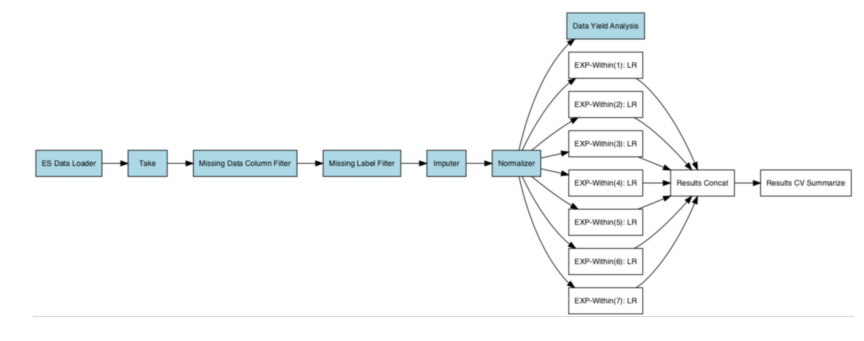

Running step EXP-Within(7): LR
  Fitting and testing LR

Running step EXP-Within(6): LR
  Fitting and testing LR

Running step EXP-Within(5): LR
  Fitting and testing LR

Running step EXP-Within(4): LR
  Fitting and testing LR

Running step EXP-Within(3): LR
  Fitting and testing LR

Running step EXP-Within(2): LR
  Fitting and testing LR

Running step EXP-Within(1): LR
  Fitting and testing LR

Running step Results Concat
  Concatenating Results


accuracy_score  f1_score  precision_score  recall_score
Method Individual                                                         
LR     1                 0.690923  0.516524         0.954751      0.354027
       2                 0.814716  0.768588         0.934959      0.652482
       3                 0.710162  0.665742         0.997921      0.499480
       4                 0.946237  0.948718         0.905383      0.996409
       5                 0.998677  0.000000         0.000000      0.000000
       6                 0.897707  0.938559         1.000000      0.884232
       7                 0.932011  0.000000         0.000000      0.000000


Running step Results CV Summarize
  Summarizing CV results table


accuracy_score            f1_score           precision_score            \
                 mean       sem      mean       sem            mean       sem   
Method                                                                          
LR           0.855776  0.045314  0.548304  0.152537        0.684716  0.177241   

       recall_score            
               mean       sem  
Method                         
LR         0.483804  0.149346


  Workflow complete



In [3]:
estimators = {"LR": LogisticRegression(solver="lbfgs",max_iter=100)}

metrics   = [accuracy_score, f1_score, precision_score, recall_score]
df_raw    = extrasensory_data_loader(label="SLEEPING");
df_sub    = Take(df_raw, 50000)
df_cf     = MisingDataColumnFilter(df_sub);
df_lf     = MisingLabelFilter(df_cf);
df_imp    = Imputer(df_lf)
df_norm   = Normalizer(df_imp);
report    = DataYieldReport(df_norm, names=["Norm"])

flow      = workflow([report]);
output    = flow.run();
num       = output['Data Yield Analysis']['report']["#Individuals with Data"]["Norm"]

res_within= ExpWithin(df_norm, estimators, metrics=metrics, n_folds=num);
res_cat   = ResultsConcat(res_within)
summary   = ResultsCVSummarize(res_cat)
flow.add([summary])
 
flow.draw(); plt.show();
output=flow.run();